In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import os
from scipy import stats
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf, acf
from scipy.stats import probplot, moment
from scipy import stats
matplotlib.rcParams['figure.figsize'] = (15, 10)
from statsmodels.tsa.arima.model import ARIMA
import statsmodels

In [2]:
statsmodels.__version__

'0.13.2'

In [3]:
try:
    os.chdir("../DataBase/files")
except FileNotFoundError:
    pass
!ls -a

.
..
.DS_Store
Archive
price_execution_data_list_16-08-2022-13-24-21.json
price_execution_data_list_16-08-2022-15-32-04.json
trade_book_data_16-08-2022-13-24-21.json
trade_book_data_16-08-2022-15-32-04.json


# Read Data

In [4]:
file_name = "price_execution_data_list"

def read_data_files(name_like: str):
    data_dict = {}
    for file_name in os.listdir():
        if name_like in file_name:
            data_dict[file_name] = pd.read_json(file_name)
    return data_dict

def aggregate_dict_to_dataframe(dictinary):
    df = pd.DataFrame()
    for key, val in dictinary.items():
        df = pd.concat([df, dictinary[key]], axis = 0)
    df.set_index("time", inplace=True)
    return df

price_execution_data = read_data_files(file_name)
price_execution_data_df = aggregate_dict_to_dataframe(price_execution_data)


del price_execution_data

price_execution_data_df = price_execution_data_df.sort_index().iloc[:10000]

# Modelling

This Notebook will only be used for classical time series Models thus we won't incorporate information from tradebook.

The goal is try to predict the price within the next (apprx) 10 seconds, since the data is not equaly spaced in time dimension as well as we investigated in EDA that on average 10 second time frame is next 13 or 14 price, thus we will try to predict each 13th quote

In [5]:
price_execution_data_df["price_forward"] = price_execution_data_df.price.shift(-13)
price_execution_data_df.dropna(inplace=True)
print(price_execution_data_df.head(20))

               symbol     price  delta_time  price_forward
time                                                      
1.660649e+09  BTCUSDT  24071.72    1.332418       24076.62
1.660649e+09  BTCUSDT  24071.40    0.611654       24076.39
1.660649e+09  BTCUSDT  24072.47    1.330175       24076.43
1.660649e+09  BTCUSDT  24073.85    0.592218       24077.94
1.660649e+09  BTCUSDT  24072.48    0.634877       24077.11
1.660649e+09  BTCUSDT  24073.51    0.613495       24076.65
1.660649e+09  BTCUSDT  24074.26    0.613733       24077.75
1.660649e+09  BTCUSDT  24074.45    0.612183       24076.70
1.660649e+09  BTCUSDT  24076.99    0.717075       24075.29
1.660649e+09  BTCUSDT  24077.29    0.614250       24074.83
1.660649e+09  BTCUSDT  24077.71    0.614570       24076.36
1.660649e+09  BTCUSDT  24077.96    0.611421       24078.89
1.660649e+09  BTCUSDT  24076.83    0.614930       24083.18
1.660649e+09  BTCUSDT  24076.62    0.613696       24082.13
1.660649e+09  BTCUSDT  24076.39    0.613431       24079.

In [6]:
train_size = int(0.7*price_execution_data_df.shape[0])
price_execution_data_df.reset_index(inplace=True)
data_train, data_test = price_execution_data_df.iloc[:train_size], price_execution_data_df.iloc[train_size:]

print(data_train.shape)
print(data_test.shape)


(6990, 5)
(2997, 5)


## AR(1)

In [22]:
model = ARIMA(data_train.price.pct_change().dropna(),
              order=(1,0,0), trend=[0,0,0,0])
model_fit = model.fit()
print(model_fit.summary())

/Users/efim/PycharmProjects/DataAnalyticsEnv/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/efim/PycharmProjects/DataAnalyticsEnv/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/efim/PycharmProjects/DataAnalyticsEnv/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                  price   No. Observations:                 6989
Model:                 ARIMA(1, 0, 0)   Log Likelihood               57062.404
Date:                Thu, 18 Aug 2022   AIC                        -114120.809
Time:                        19:11:57   BIC                        -114107.104
Sample:                             0   HQIC                       -114116.086
                               - 6989                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0524   2.46e-21  -2.13e+19      0.000      -0.052      -0.052
sigma2      4.741e-09   2.91e-11    162.981      0.000    4.68e-09     4.8e-09
Ljung-Box (L1) (Q):                   0.00   Jarque-

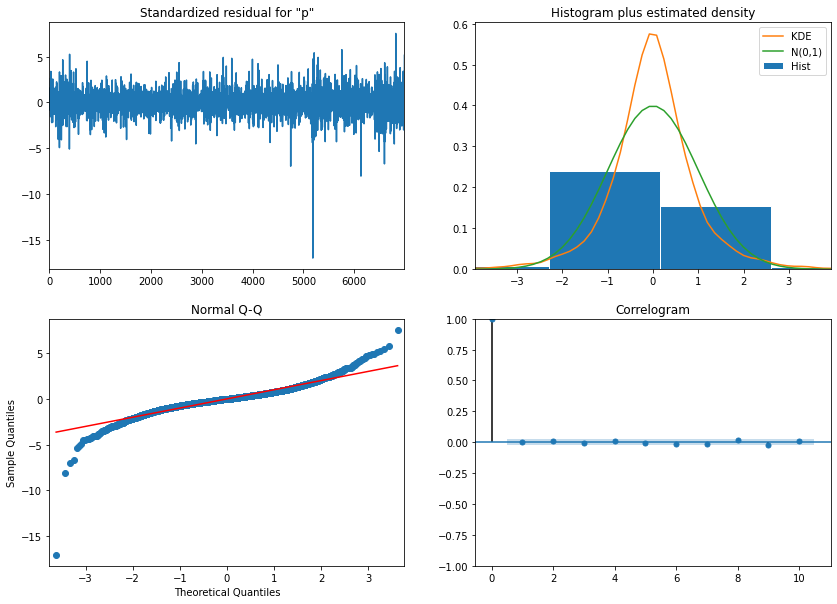

In [24]:
model_fit.plot_diagnostics(figsize=(14,10))
plt.show()

## Prediction (Recursive)

/Users/efim/PycharmProjects/DataAnalyticsEnv/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,


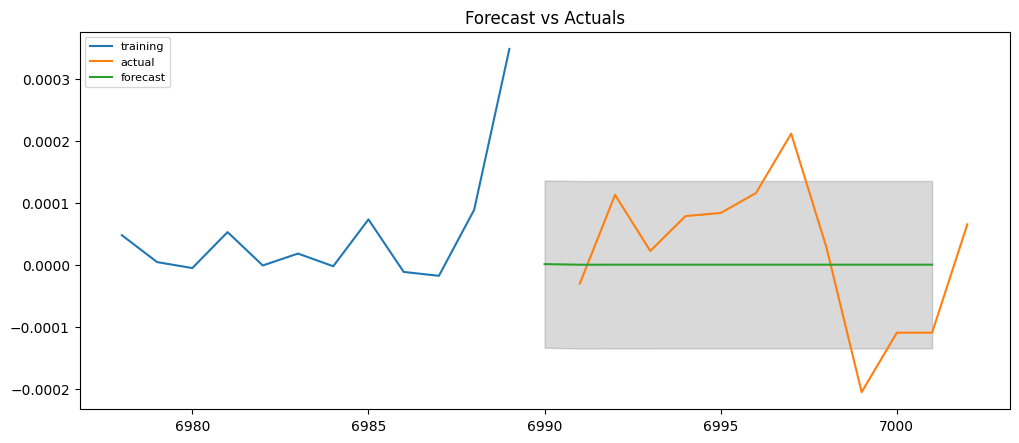

In [25]:
interval = 13
prediction = model_fit.get_forecast(interval).summary_frame()

fc_series = pd.Series(prediction["mean"], index=data_test.index[:interval])
lower_series = pd.Series(prediction.mean_ci_lower, index=data_test.index[:interval])
upper_series = pd.Series(prediction.mean_ci_upper, index=data_test.index[:interval])

#Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(data_train.price[train_size-interval:].pct_change().dropna(), label='training')
plt.plot(data_test.price[:interval].pct_change().dropna(), label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

With autoregressive lag 1 the parameter ar.L1 = 1. the model behaves like Martingale Process <eq>E[X_(t+1)|F_t]=X_t</eq>

## AR(1) using Bayesian Inference

I am not expecting to see a different result here in comparison to frequentist AR model

In [26]:
import theano
import pymc3 as pm
import arviz

# !conda remove theano
# !pip uninstall Theano Theano-PyMC PyMC3
# !pip install PyMC3
# !conda install -c conda-forge python-graphviz

WARNING (theano.configdefaults): g++ not detected ! Theano will be unable to execute optimized C-implementations (for both CPU and GPU) and will default to Python implementations. Performance will be severely degraded. To remove this warning, set Theano flags cxx to an empty string.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [27]:
data_train.price = data_train.price.pct_change()
data_train.price_forward = data_train.price_forward.pct_change()
data_train.dropna(inplace=True)

/Users/efim/PycharmProjects/DataAnalyticsEnv/venv/lib/python3.7/site-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
/Users/efim/PycharmProjects/DataAnalyticsEnv/venv/lib/python3.7/site-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


In [28]:
data_train = data_train
x = data_train.price.values[:200]
y = data_train.price.shift(-1).dropna().values[:200]

train_size = int(0.7*len(x))
x_train, x_test, y_train, y_test = x[:train_size], x[train_size:], y[:train_size], y[train_size:]

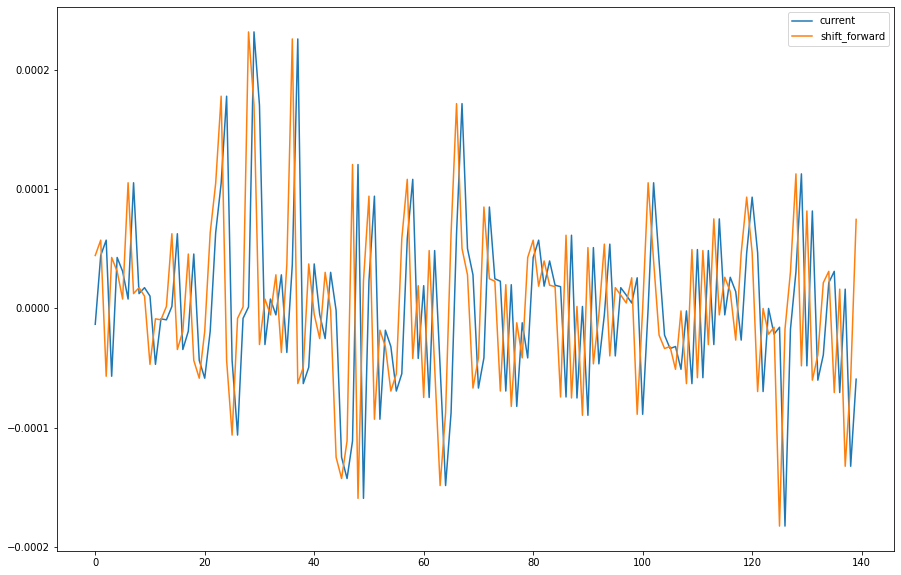

In [29]:
plt.plot(x_train,label="current")
plt.plot(y_train,label="shift_forward")
plt.legend()

In [392]:
def plot_traces(traces, burnin=0):
    summary = arviz.summary(traces[burnin:])['mean'].to_dict()
    ax = arviz.plot_trace(traces[burnin:],
                      figsize=(15, len(traces.varnames)*1.5),
                      lines=summary)

    for i, mn in enumerate(summary.values()):
        ax[i, 0].annotate(f'{mn:.2f}', xy=(mn, 0),
                          xycoords='data', xytext=(5, 10),
                          textcoords='offset points',
                          rotation=90, va='bottom',
                          fontsize='large',
                          color='#AA0022')

In [393]:
x_shared = theano.shared(x_train)
with pm.Model() as linear_regression: # model specification

    # Define priors
    sd = pm.HalfNormal('sigma', 0, sd=1) # unique name for each variable
    intercept = pm.Normal('intercept', 0, sd=20)
    slope = pm.Normal('slope', 1, sd=10)

    # Define likelihood
    likelihood = pm.Normal('y', mu = intercept + slope * x_shared, sd=sd, observed=y_train)

In [394]:
print(linear_regression)

sigma_log__ ~ TransformedDistribution
  intercept ~ Normal
      slope ~ Normal
      sigma ~ HalfNormal
          y ~ Normal


In [395]:
with linear_regression:
    manual_map_estimate = pm.find_MAP()
print(manual_map_estimate)

/Users/efim/PycharmProjects/DataAnalyticsEnv/venv/lib/python3.7/site-packages/theano/tensor/elemwise.py:826: RuntimeWarning: divide by zero encountered in log
  variables = ufunc(*ufunc_args, **ufunc_kwargs)
/Users/efim/PycharmProjects/DataAnalyticsEnv/venv/lib/python3.7/site-packages/theano/tensor/elemwise.py:826: RuntimeWarning: invalid value encountered in multiply
  variables = ufunc(*ufunc_args, **ufunc_kwargs)
/Users/efim/PycharmProjects/DataAnalyticsEnv/venv/lib/python3.7/site-packages/theano/tensor/elemwise.py:826: RuntimeWarning: invalid value encountered in log
  variables = ufunc(*ufunc_args, **ufunc_kwargs)



{'sigma_log__': array(-9.25595814), 'intercept': array(6.2834266e-07), 'slope': array(0.99999955), 'sigma': array(9.55407077e-05)}


In [397]:
with linear_regression:
    # Inference
    trace = pm.sample(draws=2000, # draw samples from posterior using NUTS sampling
                      tune=500,
                      chains = 4,
                      cores=4,
                      step = pm.Metropolis()) 

/Users/efim/PycharmProjects/DataAnalyticsEnv/venv/lib/python3.7/site-packages/deprecat/classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [slope]
>Metropolis: [intercept]
>Metropolis: [sigma]


Sampling 4 chains for 500 tune and 2_000 draw iterations (2_000 + 8_000 draws total) took 85 seconds.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


Got error No model on context stack. trying to find log_likelihood in translation.
/Users/efim/PycharmProjects/DataAnalyticsEnv/venv/lib/python3.7/site-packages/arviz/data/io_pymc3_3x.py:102: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,
Got error No model on context stack. trying to find log_likelihood in translation.
/Users/efim/PycharmProjects/DataAnalyticsEnv/venv/lib/python3.7/site-packages/arviz/data/io_pymc3_3x.py:102: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,
Got error No model on context stack. trying to find log_likelihood in translation.
/Users/efim/P

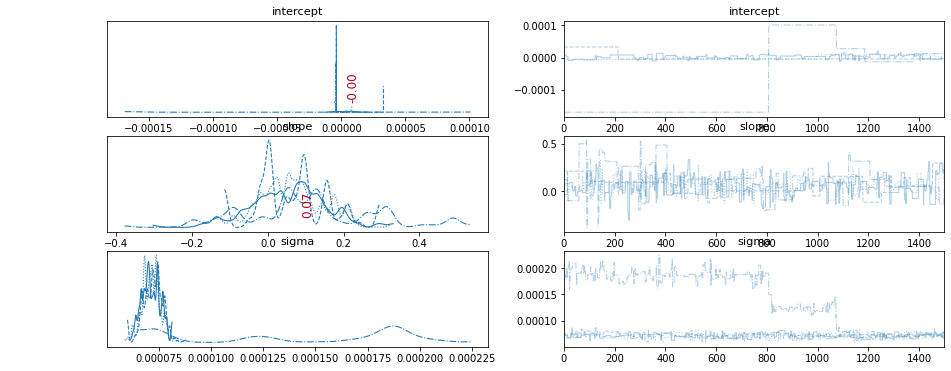

In [398]:
plot_traces(trace, burnin=500)

#### Does not seem that model converge, or it has different stationary distribution states

In [404]:
# For some reasons posterior estimates failed to plot (if we run using prices not returns), lets analyze why

def unpack_trace(trace_):
    trace_data = []
    trace_data_chain = {var_name: [] for var_name in trace.varnames}
    trace_length = len(list(trace.points())) /  trace.nchains
    count = 1
    for i, tr in enumerate(list(trace.points())):
        if count == trace_length:
            count = 0
            trace_data.append(trace_data_chain)
            trace_data_chain = {var_name: [] for var_name in trace.varnames}
        count+=1
        for k,v in tr.items():
            trace_data_chain[k].append(v)
    return trace_data

trace_data = unpack_trace(trace)

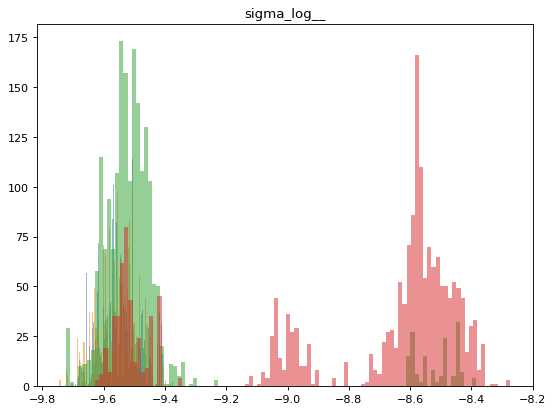

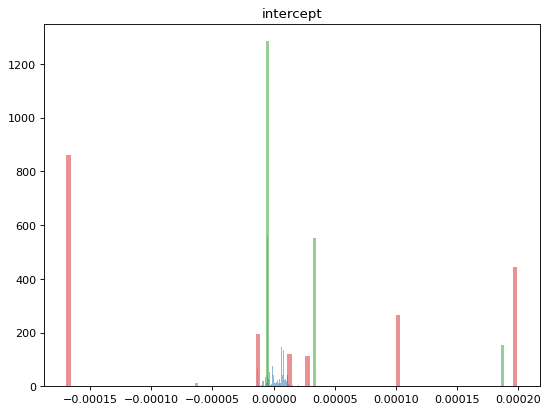

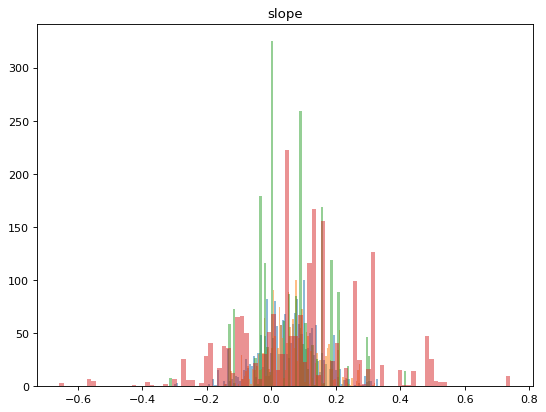

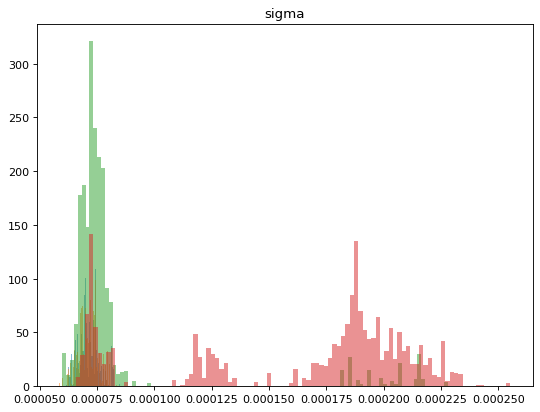

In [400]:
for var_name in trace.varnames:
    plt.figure(figsize=(8, 6), dpi=80)
    for trace_num in range(trace.nchains):
        plt.hist(trace_data[trace_num][var_name], bins=100,alpha=0.5, label = f"{trace_num}")
    plt.title(var_name)
    plt.show()

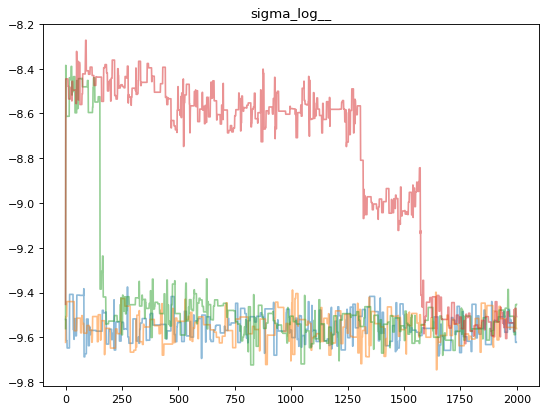

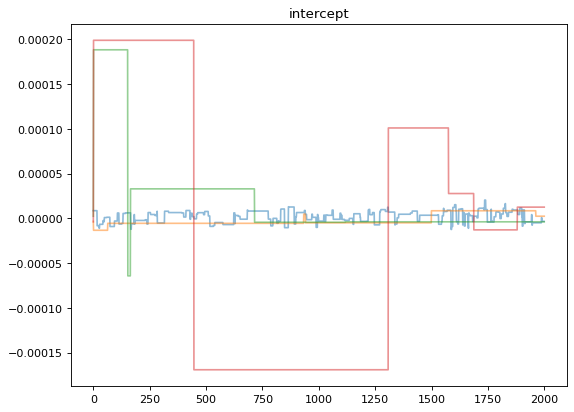

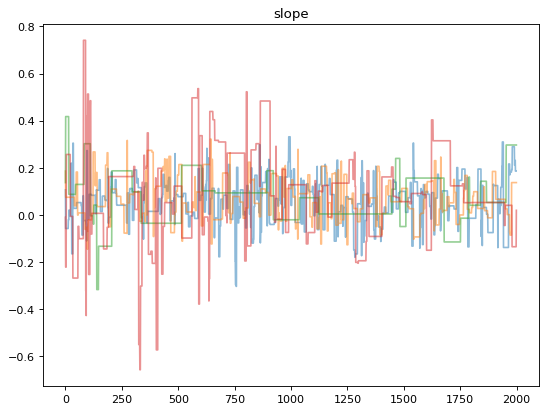

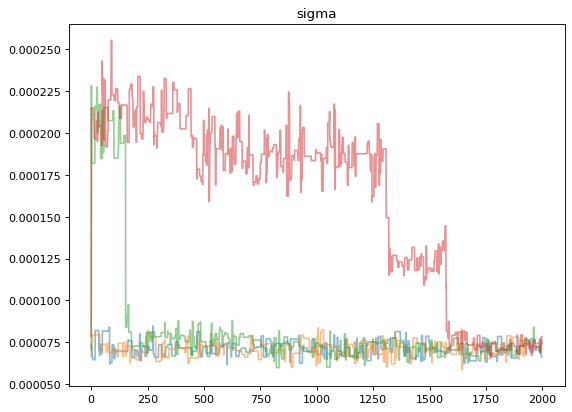

In [401]:
for var_name in trace.varnames:
    plt.figure(figsize=(8, 6), dpi=80)
    for trace_num in range(trace.nchains):
        plt.plot(trace_data[trace_num][var_name],alpha=0.5, label = f"{trace_num}")
    plt.title(var_name)
    plt.show()

In [381]:
trace.mean_tree_accept.mean()

AttributeError: 'MultiTrace' object has no attribute 'mean_tree_accept'

In [382]:
accept = trace.get_sampler_stats('mean_tree_accept', burn=1000)
plt.hist(accept)
plt.show()

KeyError: 'Unknown sampler statistic mean_tree_accept'

/Users/efim/PycharmProjects/DataAnalyticsEnv/venv/lib/python3.7/site-packages/pymc3/sampling.py:1709: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "


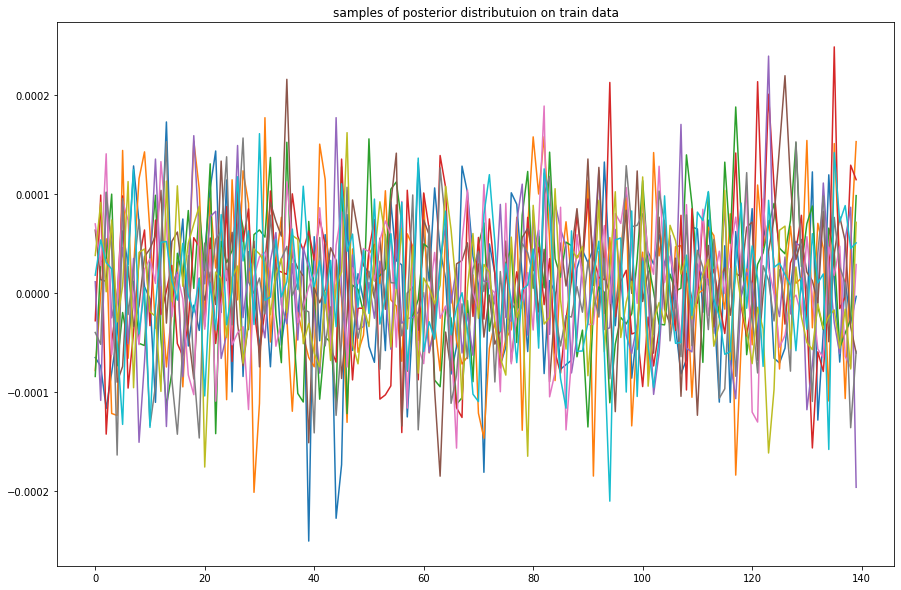

In [402]:
x_shared.set_value(x_train)
ppc = pm.sample_posterior_predictive(trace,
                                     model=linear_regression,
                                     samples=10)
plt.plot(ppc["y"].T)
plt.title("samples of posterior distributuion on train data")
plt.show()

/Users/efim/PycharmProjects/DataAnalyticsEnv/venv/lib/python3.7/site-packages/pymc3/sampling.py:1709: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "


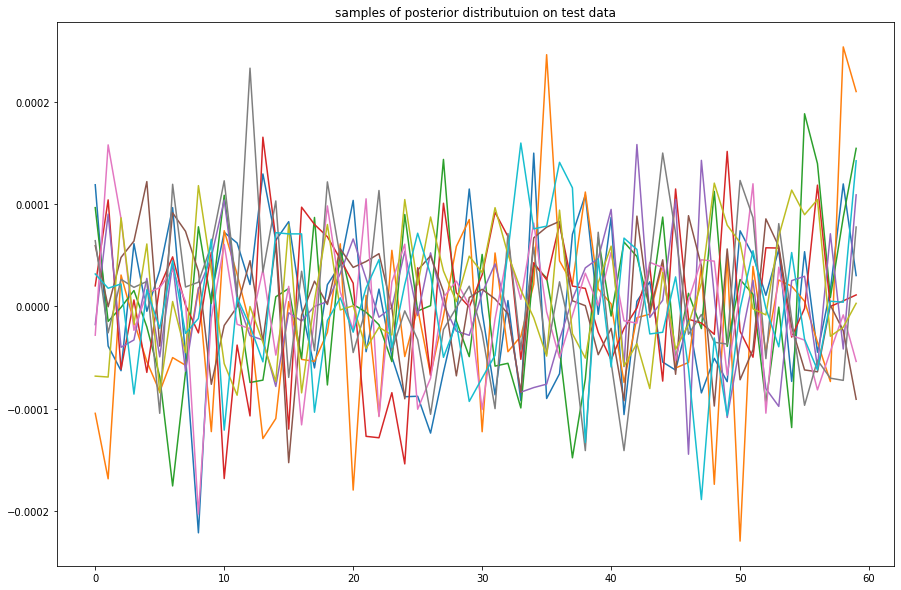

In [403]:
x_shared.set_value(x_test)
ppc = pm.sample_posterior_predictive(trace,
                                     model=linear_regression,
                                     samples=10)
plt.plot(ppc["y"].T)
plt.title("samples of posterior distributuion on test data")
plt.show()